In [1]:
from climpyrical.gridding import scale_model_obs
from climpyrical.mask import stratify_coords
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from sklearn.neighbors import NearestNeighbors
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# parameter cell

In [3]:
# Parameters
name = "SL50"
station_dv = "SL50 (kPa)"
station_path = "data/station_inputs/sl50_rl50_for_maps.csv"
input_model_path = (
    "data/model_inputs/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc"
)
medians = {"value": 2.5, "action": "multiply"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"
nbcc_median_correction = False


Load processed moded, target canada-only mask, and the Upper Artic Area mask 

In [4]:
# Hard coded CanRCM4 upper model domain rlat
dsold_max = 28.15999984741211

ds = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
(dv, ) = ds.data_vars

mask = read_data(
    resource_filename(
        'climpyrical',
        mask_path
    ))['mask'].values

northern_mask = read_data(
    resource_filename(
        'climpyrical',
        north_mask_path
    )
)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

Load processed station data

In [5]:
df = pd.read_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), 
    index_col=False
)
df.head(3)

,irlat,irlon,SL50 (kPa),rlat,rlon,lat,lon,elev (m),station_name,province,model_values,ratio
0,558,1009,1.0,-4.286849,10.373390,42.2756,-82.9556,190.0,WINDSOR A,ON,0.614799,1.178766
1,559,1009,1.2,-4.227125,10.379271,42.3333,-82.9333,188.0,WINDSOR RIVERSIDE,ON,0.622597,1.396802
2,576,1017,1.5,-3.494586,10.713492,42.9922,-82.3047,181.0,SARNIA AIRPORT,ON,0.739112,1.470759


In [6]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    K = 273.15
    df[station_dv] += K
    df["model_values"] += K
    ds[dv] += K

Separate stations into beyond and within the model domain

In [7]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

Check for sets of stations that are identical. This would produce idential windows over a geographic area and disproportionately weight them in the averaged ratio field.

In [8]:
X_distances = np.stack([np.deg2rad(df_south.lat.values), np.deg2rad(df_south.lon.values)])
nbrs = NearestNeighbors(n_neighbors=30, metric="haversine").fit(
    X_distances.T
)

# Order independent window checkers
# only uses windows that are not-identical

dist, ind = nbrs.kneighbors(X_distances.T)
good_i = []
list_of_sets = []
count = 0 
for i in range(df_south.shape[0]):
    list_of_sets.append(df_south[["lon", "lat", station_dv]].iloc[ind[i]].values)
    if i+1-count == np.unique(list_of_sets, axis=0).shape[0]:
        good_i.append(i)
    else:
        warning.warn("There are identical windows!")
        count += 1 

df_south = df_south.iloc[good_i]

Calculate the station average in the UAA

In [9]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])
UAA_station_mean

1.5000000000000002

Use the best tolerance scaling to scale the model values. The ratio is already automatically scaled.

In [10]:
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

Perform ratio kriging on the set of stations below the maximum CanRCM4 native domain.

In [11]:
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 2/514 [00:00<02:37,  3.26it/s]

  1%|          | 3/514 [00:01<03:30,  2.43it/s]

  1%|          | 4/514 [00:01<03:39,  2.32it/s]

  1%|          | 5/514 [00:02<03:51,  2.20it/s]

  1%|          | 6/514 [00:02<04:01,  2.11it/s]

  1%|▏         | 7/514 [00:03<04:11,  2.01it/s]

  2%|▏         | 8/514 [00:03<04:10,  2.02it/s]

  2%|▏         | 9/514 [00:04<04:26,  1.90it/s]

  2%|▏         | 10/514 [00:04<04:31,  1.86it/s]

  2%|▏         | 11/514 [00:05<04:29,  1.87it/s]

  2%|▏         | 12/514 [00:06<04:34,  1.83it/s]

  3%|▎         | 13/514 [00:06<04:38,  1.80it/s]

  3%|▎         | 14/514 [00:07<04:46,  1.74it/s]

  3%|▎         | 15/514 [00:07<05:04,  1.64it/s]

  3%|▎         | 16/514 [00:08<05:01,  1.65it/s]

  3%|▎         | 17/514 [00:09<05:05,  1.63it/s]

  4%|▎         | 18/514 [00:09<05:06,  1.62it/s]

  4%|▎         | 19/514 [00:10<05:09,  1.60it/s]

  4%|▍         | 20/514 [00:11<05:06,  1.61it/s]

  4%|▍         | 21/514 [00:11<05:12,  1.58it/s]

  4%|▍         | 22/514 [00:12<05:08,  1.59it/s]

  4%|▍         | 23/514 [00:13<05:26,  1.50it/s]

  5%|▍         | 24/514 [00:13<05:46,  1.41it/s]

  5%|▍         | 25/514 [00:14<05:37,  1.45it/s]

  5%|▌         | 26/514 [00:15<05:20,  1.52it/s]

  5%|▌         | 27/514 [00:15<05:08,  1.58it/s]

  5%|▌         | 28/514 [00:16<05:11,  1.56it/s]

  6%|▌         | 29/514 [00:17<07:03,  1.15it/s]

  6%|▌         | 30/514 [00:19<08:24,  1.04s/it]

  6%|▌         | 31/514 [00:19<07:24,  1.09it/s]

  6%|▌         | 32/514 [00:20<06:40,  1.20it/s]

  6%|▋         | 33/514 [00:21<07:58,  1.00it/s]

  7%|▋         | 34/514 [00:22<07:02,  1.14it/s]

  7%|▋         | 35/514 [00:24<08:54,  1.12s/it]

  7%|▋         | 36/514 [00:25<09:21,  1.17s/it]

  7%|▋         | 37/514 [00:27<10:55,  1.37s/it]

  7%|▋         | 38/514 [00:29<12:03,  1.52s/it]

  8%|▊         | 39/514 [00:30<11:32,  1.46s/it]

  8%|▊         | 40/514 [00:31<09:31,  1.21s/it]

  8%|▊         | 41/514 [00:33<11:17,  1.43s/it]

  8%|▊         | 42/514 [00:34<11:39,  1.48s/it]

  8%|▊         | 43/514 [00:35<09:41,  1.24s/it]

  9%|▊         | 44/514 [00:35<08:17,  1.06s/it]

  9%|▉         | 45/514 [00:36<07:18,  1.07it/s]

  9%|▉         | 46/514 [00:37<07:09,  1.09it/s]

  9%|▉         | 47/514 [00:38<08:15,  1.06s/it]

  9%|▉         | 48/514 [00:40<08:48,  1.13s/it]

 10%|▉         | 49/514 [00:42<10:26,  1.35s/it]

 10%|▉         | 50/514 [00:43<10:15,  1.33s/it]

 10%|▉         | 51/514 [00:45<11:40,  1.51s/it]

 10%|█         | 52/514 [00:45<09:30,  1.23s/it]

 10%|█         | 53/514 [00:47<10:58,  1.43s/it]

 11%|█         | 54/514 [00:49<12:19,  1.61s/it]

 11%|█         | 55/514 [00:51<11:58,  1.57s/it]

 11%|█         | 56/514 [00:51<09:53,  1.30s/it]

 11%|█         | 57/514 [00:53<11:31,  1.51s/it]

 11%|█▏        | 58/514 [00:55<12:24,  1.63s/it]

 11%|█▏        | 59/514 [00:57<13:36,  1.79s/it]

 12%|█▏        | 60/514 [01:00<14:09,  1.87s/it]

 12%|█▏        | 61/514 [01:00<11:25,  1.51s/it]

 12%|█▏        | 62/514 [01:01<09:27,  1.26s/it]

 12%|█▏        | 63/514 [01:03<11:18,  1.51s/it]

 12%|█▏        | 64/514 [01:05<12:37,  1.68s/it]

 13%|█▎        | 65/514 [01:07<13:26,  1.80s/it]

 13%|█▎        | 66/514 [01:09<12:59,  1.74s/it]

 13%|█▎        | 67/514 [01:11<13:05,  1.76s/it]

 13%|█▎        | 68/514 [01:13<13:39,  1.84s/it]

 13%|█▎        | 69/514 [01:15<14:08,  1.91s/it]

 14%|█▎        | 70/514 [01:17<14:15,  1.93s/it]

 14%|█▍        | 71/514 [01:19<14:15,  1.93s/it]

 14%|█▍        | 72/514 [01:21<14:25,  1.96s/it]

 14%|█▍        | 73/514 [01:23<14:55,  2.03s/it]

 14%|█▍        | 74/514 [01:25<14:48,  2.02s/it]

 15%|█▍        | 75/514 [01:27<14:42,  2.01s/it]

 15%|█▍        | 76/514 [01:29<15:06,  2.07s/it]

 15%|█▍        | 77/514 [01:30<11:48,  1.62s/it]

 15%|█▌        | 78/514 [01:31<11:17,  1.55s/it]

 15%|█▌        | 79/514 [01:33<11:48,  1.63s/it]

 16%|█▌        | 80/514 [01:35<12:28,  1.72s/it]

 16%|█▌        | 81/514 [01:37<13:09,  1.82s/it]

 16%|█▌        | 82/514 [01:38<12:09,  1.69s/it]

 16%|█▌        | 83/514 [01:39<09:46,  1.36s/it]

 16%|█▋        | 84/514 [01:41<10:56,  1.53s/it]

 17%|█▋        | 85/514 [01:43<12:14,  1.71s/it]

 17%|█▋        | 86/514 [01:43<09:51,  1.38s/it]

 17%|█▋        | 87/514 [01:44<08:09,  1.15s/it]

 17%|█▋        | 88/514 [01:46<10:40,  1.50s/it]

 17%|█▋        | 89/514 [01:48<11:33,  1.63s/it]

 18%|█▊        | 90/514 [01:49<10:38,  1.51s/it]

 18%|█▊        | 91/514 [01:50<08:42,  1.24s/it]

 18%|█▊        | 92/514 [01:51<07:16,  1.04s/it]

 18%|█▊        | 93/514 [01:52<09:04,  1.29s/it]

 18%|█▊        | 94/514 [01:54<08:49,  1.26s/it]

 18%|█▊        | 95/514 [01:56<10:04,  1.44s/it]

 19%|█▊        | 96/514 [01:56<08:13,  1.18s/it]

 19%|█▉        | 97/514 [01:57<06:56,  1.00it/s]

 19%|█▉        | 98/514 [01:59<08:38,  1.25s/it]

 19%|█▉        | 99/514 [02:00<09:53,  1.43s/it]

 19%|█▉        | 100/514 [02:02<11:02,  1.60s/it]

 20%|█▉        | 101/514 [02:03<08:55,  1.30s/it]

 20%|█▉        | 102/514 [02:04<08:48,  1.28s/it]

 20%|██        | 103/514 [02:06<10:10,  1.49s/it]

 20%|██        | 104/514 [02:08<11:17,  1.65s/it]

 20%|██        | 105/514 [02:09<09:06,  1.34s/it]

 21%|██        | 106/514 [02:09<07:37,  1.12s/it]

 21%|██        | 107/514 [02:10<06:32,  1.04it/s]

 21%|██        | 108/514 [02:11<06:15,  1.08it/s]

 21%|██        | 109/514 [02:12<06:52,  1.02s/it]

 21%|██▏       | 110/514 [02:14<07:40,  1.14s/it]

 22%|██▏       | 111/514 [02:14<06:41,  1.00it/s]

 22%|██▏       | 112/514 [02:16<08:44,  1.30s/it]

 22%|██▏       | 113/514 [02:17<08:32,  1.28s/it]

 22%|██▏       | 114/514 [02:19<08:23,  1.26s/it]

 22%|██▏       | 115/514 [02:19<07:05,  1.07s/it]

 23%|██▎       | 116/514 [02:20<06:10,  1.08it/s]

 23%|██▎       | 117/514 [02:20<05:32,  1.19it/s]

 23%|██▎       | 118/514 [02:21<05:03,  1.31it/s]

 23%|██▎       | 119/514 [02:22<06:01,  1.09it/s]

 23%|██▎       | 120/514 [02:23<05:21,  1.22it/s]

 24%|██▎       | 121/514 [02:24<04:54,  1.33it/s]

 24%|██▎       | 122/514 [02:24<04:46,  1.37it/s]

 24%|██▍       | 123/514 [02:25<04:26,  1.47it/s]

 24%|██▍       | 124/514 [02:25<04:17,  1.51it/s]

 24%|██▍       | 125/514 [02:26<04:07,  1.57it/s]

 25%|██▍       | 126/514 [02:27<04:06,  1.58it/s]

 25%|██▍       | 127/514 [02:27<03:58,  1.62it/s]

 25%|██▍       | 128/514 [02:28<05:09,  1.25it/s]

 25%|██▌       | 129/514 [02:30<06:53,  1.07s/it]

 25%|██▌       | 130/514 [02:31<05:56,  1.08it/s]

 25%|██▌       | 131/514 [02:31<05:18,  1.20it/s]

 26%|██▌       | 132/514 [02:33<06:18,  1.01it/s]

 26%|██▌       | 133/514 [02:34<06:33,  1.03s/it]

 26%|██▌       | 134/514 [02:35<06:44,  1.07s/it]

 26%|██▋       | 135/514 [02:36<05:55,  1.07it/s]

 26%|██▋       | 136/514 [02:36<05:17,  1.19it/s]

 27%|██▋       | 137/514 [02:37<04:49,  1.30it/s]

 27%|██▋       | 138/514 [02:37<04:26,  1.41it/s]

 27%|██▋       | 139/514 [02:39<05:50,  1.07it/s]

 27%|██▋       | 140/514 [02:40<06:41,  1.07s/it]

 27%|██▋       | 141/514 [02:41<05:45,  1.08it/s]

 28%|██▊       | 142/514 [02:41<05:08,  1.20it/s]

 28%|██▊       | 143/514 [02:43<05:51,  1.06it/s]

 28%|██▊       | 144/514 [02:44<06:24,  1.04s/it]

 28%|██▊       | 145/514 [02:44<05:29,  1.12it/s]

 28%|██▊       | 146/514 [02:45<04:54,  1.25it/s]

 29%|██▊       | 147/514 [02:46<04:27,  1.37it/s]

 29%|██▉       | 148/514 [02:46<04:07,  1.48it/s]

 29%|██▉       | 149/514 [02:47<04:58,  1.22it/s]

 29%|██▉       | 150/514 [02:48<04:38,  1.31it/s]

 29%|██▉       | 151/514 [02:49<04:15,  1.42it/s]

 30%|██▉       | 152/514 [02:50<05:04,  1.19it/s]

 30%|██▉       | 153/514 [02:50<04:47,  1.26it/s]

 30%|██▉       | 154/514 [02:51<04:23,  1.36it/s]

 30%|███       | 155/514 [02:53<06:05,  1.02s/it]

 30%|███       | 156/514 [02:54<06:48,  1.14s/it]

 31%|███       | 157/514 [02:55<05:48,  1.02it/s]

 31%|███       | 158/514 [02:56<06:47,  1.14s/it]

 31%|███       | 159/514 [02:58<07:47,  1.32s/it]

 31%|███       | 160/514 [02:59<07:37,  1.29s/it]

 31%|███▏      | 161/514 [03:00<07:13,  1.23s/it]

 32%|███▏      | 162/514 [03:01<06:02,  1.03s/it]

 32%|███▏      | 163/514 [03:01<05:17,  1.10it/s]

 32%|███▏      | 164/514 [03:02<04:44,  1.23it/s]

 32%|███▏      | 165/514 [03:04<06:20,  1.09s/it]

 32%|███▏      | 166/514 [03:05<06:30,  1.12s/it]

 32%|███▏      | 167/514 [03:06<06:34,  1.14s/it]

 33%|███▎      | 168/514 [03:07<06:33,  1.14s/it]

 33%|███▎      | 169/514 [03:08<06:41,  1.16s/it]

 33%|███▎      | 170/514 [03:10<07:15,  1.27s/it]

 33%|███▎      | 171/514 [03:11<07:01,  1.23s/it]

 33%|███▎      | 172/514 [03:13<07:21,  1.29s/it]

 34%|███▎      | 173/514 [03:14<07:07,  1.25s/it]

 34%|███▍      | 174/514 [03:15<07:02,  1.24s/it]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: In addition: 


R[write to console]: Warning messages:



R[write to console]: 1: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: 2: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: Timing stopped at: 0.034 0.001 0.032



 34%|███▍      | 175/514 [03:15<05:14,  1.08it/s]

 34%|███▍      | 176/514 [03:16<04:42,  1.20it/s]

 34%|███▍      | 177/514 [03:17<06:00,  1.07s/it]

 35%|███▍      | 178/514 [03:19<06:34,  1.17s/it]

 35%|███▍      | 179/514 [03:21<07:51,  1.41s/it]

 35%|███▌      | 180/514 [03:22<07:18,  1.31s/it]

 35%|███▌      | 181/514 [03:23<07:11,  1.30s/it]

 35%|███▌      | 182/514 [03:24<06:01,  1.09s/it]

 36%|███▌      | 183/514 [03:25<06:13,  1.13s/it]

 36%|███▌      | 184/514 [03:26<05:33,  1.01s/it]

 36%|███▌      | 185/514 [03:26<04:51,  1.13it/s]

 36%|███▌      | 186/514 [03:27<04:30,  1.21it/s]

 36%|███▋      | 187/514 [03:29<05:45,  1.06s/it]

 37%|███▋      | 188/514 [03:30<06:27,  1.19s/it]

 37%|███▋      | 189/514 [03:32<07:07,  1.31s/it]

 37%|███▋      | 190/514 [03:33<07:15,  1.34s/it]

 37%|███▋      | 191/514 [03:35<07:50,  1.46s/it]

 37%|███▋      | 192/514 [03:36<07:15,  1.35s/it]

 38%|███▊      | 193/514 [03:36<05:59,  1.12s/it]

 38%|███▊      | 194/514 [03:38<07:03,  1.32s/it]

 38%|███▊      | 195/514 [03:40<07:38,  1.44s/it]

 38%|███▊      | 196/514 [03:41<07:11,  1.36s/it]

 38%|███▊      | 197/514 [03:42<07:03,  1.34s/it]

 39%|███▊      | 198/514 [03:44<07:55,  1.50s/it]

 39%|███▊      | 199/514 [03:46<07:31,  1.43s/it]

 39%|███▉      | 200/514 [03:47<07:26,  1.42s/it]

 39%|███▉      | 201/514 [03:48<07:24,  1.42s/it]

 39%|███▉      | 202/514 [03:50<07:04,  1.36s/it]

 39%|███▉      | 203/514 [03:51<06:38,  1.28s/it]

 40%|███▉      | 204/514 [03:52<07:00,  1.36s/it]

 40%|███▉      | 205/514 [03:54<06:57,  1.35s/it]

 40%|████      | 206/514 [03:55<07:21,  1.43s/it]

 40%|████      | 207/514 [03:56<07:07,  1.39s/it]

 40%|████      | 208/514 [03:58<07:17,  1.43s/it]

 41%|████      | 209/514 [03:59<07:20,  1.45s/it]

 41%|████      | 210/514 [04:01<07:14,  1.43s/it]

 41%|████      | 211/514 [04:02<06:59,  1.38s/it]

 41%|████      | 212/514 [04:03<05:43,  1.14s/it]

 41%|████▏     | 213/514 [04:04<06:25,  1.28s/it]

 42%|████▏     | 214/514 [04:06<07:09,  1.43s/it]

 42%|████▏     | 215/514 [04:08<07:28,  1.50s/it]

 42%|████▏     | 216/514 [04:09<07:17,  1.47s/it]

 42%|████▏     | 217/514 [04:11<07:28,  1.51s/it]

 42%|████▏     | 218/514 [04:12<07:39,  1.55s/it]

 43%|████▎     | 219/514 [04:14<08:00,  1.63s/it]

 43%|████▎     | 220/514 [04:16<07:53,  1.61s/it]

 43%|████▎     | 221/514 [04:16<06:20,  1.30s/it]

 43%|████▎     | 222/514 [04:18<06:18,  1.30s/it]

 43%|████▎     | 223/514 [04:19<06:32,  1.35s/it]

 44%|████▎     | 224/514 [04:20<06:07,  1.27s/it]

 44%|████▍     | 225/514 [04:21<05:05,  1.06s/it]

 44%|████▍     | 226/514 [04:22<05:03,  1.05s/it]

 44%|████▍     | 227/514 [04:23<05:07,  1.07s/it]

 44%|████▍     | 228/514 [04:23<04:21,  1.09it/s]

 45%|████▍     | 229/514 [04:24<03:52,  1.23it/s]

 45%|████▍     | 230/514 [04:25<04:12,  1.13it/s]

 45%|████▍     | 231/514 [04:26<03:48,  1.24it/s]

 45%|████▌     | 232/514 [04:27<04:59,  1.06s/it]

 45%|████▌     | 233/514 [04:29<05:43,  1.22s/it]

 46%|████▌     | 234/514 [04:30<06:00,  1.29s/it]

 46%|████▌     | 235/514 [04:32<05:58,  1.29s/it]

 46%|████▌     | 236/514 [04:33<06:16,  1.35s/it]

 46%|████▌     | 237/514 [04:35<06:11,  1.34s/it]

 46%|████▋     | 238/514 [04:36<06:08,  1.34s/it]

 46%|████▋     | 239/514 [04:37<06:13,  1.36s/it]

 47%|████▋     | 240/514 [04:39<06:11,  1.35s/it]

 47%|████▋     | 241/514 [04:39<05:09,  1.13s/it]

 47%|████▋     | 242/514 [04:41<05:49,  1.29s/it]

 47%|████▋     | 243/514 [04:42<05:58,  1.32s/it]

 47%|████▋     | 244/514 [04:44<05:48,  1.29s/it]

 48%|████▊     | 245/514 [04:44<04:51,  1.09s/it]

 48%|████▊     | 246/514 [04:45<04:07,  1.08it/s]

 48%|████▊     | 247/514 [04:45<03:37,  1.23it/s]

 48%|████▊     | 248/514 [04:47<04:20,  1.02it/s]

 48%|████▊     | 249/514 [04:48<04:44,  1.07s/it]

 49%|████▊     | 250/514 [04:49<04:56,  1.12s/it]

 49%|████▉     | 251/514 [04:50<04:14,  1.03it/s]

 49%|████▉     | 252/514 [04:51<04:37,  1.06s/it]

 49%|████▉     | 253/514 [04:52<04:43,  1.09s/it]

 49%|████▉     | 254/514 [04:54<05:09,  1.19s/it]

 50%|████▉     | 255/514 [04:55<05:44,  1.33s/it]

 50%|████▉     | 256/514 [04:57<06:24,  1.49s/it]

 50%|█████     | 257/514 [04:59<06:39,  1.56s/it]

 50%|█████     | 258/514 [05:00<06:30,  1.52s/it]

 50%|█████     | 259/514 [05:02<06:14,  1.47s/it]

 51%|█████     | 260/514 [05:03<05:57,  1.41s/it]

 51%|█████     | 261/514 [05:04<05:58,  1.42s/it]

 51%|█████     | 262/514 [05:06<06:08,  1.46s/it]

 51%|█████     | 263/514 [05:07<06:09,  1.47s/it]

 51%|█████▏    | 264/514 [05:09<06:32,  1.57s/it]

 52%|█████▏    | 265/514 [05:11<06:31,  1.57s/it]

 52%|█████▏    | 266/514 [05:12<06:11,  1.50s/it]

 52%|█████▏    | 267/514 [05:14<06:15,  1.52s/it]

 52%|█████▏    | 268/514 [05:15<06:16,  1.53s/it]

 52%|█████▏    | 269/514 [05:17<06:03,  1.48s/it]

 53%|█████▎    | 270/514 [05:18<05:50,  1.44s/it]

 53%|█████▎    | 271/514 [05:19<05:39,  1.40s/it]

 53%|█████▎    | 272/514 [05:21<05:45,  1.43s/it]

 53%|█████▎    | 273/514 [05:21<04:40,  1.16s/it]

 53%|█████▎    | 274/514 [05:22<03:57,  1.01it/s]

 54%|█████▎    | 275/514 [05:23<04:08,  1.04s/it]

 54%|█████▎    | 276/514 [05:24<04:37,  1.16s/it]

 54%|█████▍    | 277/514 [05:26<04:54,  1.24s/it]

 54%|█████▍    | 278/514 [05:27<05:13,  1.33s/it]

 54%|█████▍    | 279/514 [05:29<05:03,  1.29s/it]

 54%|█████▍    | 280/514 [05:30<05:06,  1.31s/it]

 55%|█████▍    | 281/514 [05:31<05:09,  1.33s/it]

 55%|█████▍    | 282/514 [05:32<04:51,  1.25s/it]

 55%|█████▌    | 283/514 [05:34<05:06,  1.33s/it]

 55%|█████▌    | 284/514 [05:35<05:08,  1.34s/it]

 55%|█████▌    | 285/514 [05:37<05:19,  1.40s/it]

 56%|█████▌    | 286/514 [05:39<05:45,  1.51s/it]

 56%|█████▌    | 287/514 [05:39<04:43,  1.25s/it]

 56%|█████▌    | 288/514 [05:40<04:31,  1.20s/it]

 56%|█████▌    | 289/514 [05:41<04:30,  1.20s/it]

 56%|█████▋    | 290/514 [05:43<04:27,  1.19s/it]

 57%|█████▋    | 291/514 [05:44<04:54,  1.32s/it]

 57%|█████▋    | 292/514 [05:46<05:18,  1.43s/it]

 57%|█████▋    | 293/514 [05:47<05:08,  1.40s/it]

 57%|█████▋    | 294/514 [05:49<05:06,  1.39s/it]

 57%|█████▋    | 295/514 [05:50<05:03,  1.39s/it]

 58%|█████▊    | 296/514 [05:51<04:51,  1.34s/it]

 58%|█████▊    | 297/514 [05:53<05:08,  1.42s/it]

 58%|█████▊    | 298/514 [05:55<05:25,  1.51s/it]

 58%|█████▊    | 299/514 [05:56<05:37,  1.57s/it]

 58%|█████▊    | 300/514 [05:58<05:49,  1.63s/it]

 59%|█████▊    | 301/514 [06:00<05:50,  1.65s/it]

 59%|█████▉    | 302/514 [06:01<05:01,  1.42s/it]

 59%|█████▉    | 303/514 [06:02<05:14,  1.49s/it]

 59%|█████▉    | 304/514 [06:04<05:13,  1.49s/it]

 59%|█████▉    | 305/514 [06:06<05:23,  1.55s/it]

 60%|█████▉    | 306/514 [06:07<05:28,  1.58s/it]

 60%|█████▉    | 307/514 [06:09<05:45,  1.67s/it]

 60%|█████▉    | 308/514 [06:11<05:45,  1.68s/it]

 60%|██████    | 309/514 [06:12<05:33,  1.63s/it]

 60%|██████    | 310/514 [06:14<05:17,  1.55s/it]

 61%|██████    | 311/514 [06:15<05:15,  1.56s/it]

 61%|██████    | 312/514 [06:17<05:23,  1.60s/it]

R[write to console]: Error in if (any(d < 0)) stop("distance argument must be nonnegative") : 
  missing value where TRUE/FALSE needed



R[write to console]: Timing stopped at: 0.057 0 0.057



 61%|██████    | 313/514 [06:18<04:53,  1.46s/it]

 61%|██████    | 314/514 [06:19<04:09,  1.25s/it]

 61%|██████▏   | 315/514 [06:20<04:04,  1.23s/it]

 61%|██████▏   | 316/514 [06:21<04:11,  1.27s/it]

 62%|██████▏   | 317/514 [06:23<04:34,  1.39s/it]

 62%|██████▏   | 318/514 [06:24<04:34,  1.40s/it]

 62%|██████▏   | 319/514 [06:26<05:03,  1.56s/it]

 62%|██████▏   | 320/514 [06:28<04:59,  1.54s/it]

 62%|██████▏   | 321/514 [06:29<04:45,  1.48s/it]

 63%|██████▎   | 322/514 [06:31<04:51,  1.52s/it]

 63%|██████▎   | 323/514 [06:32<04:48,  1.51s/it]

 63%|██████▎   | 324/514 [06:34<05:01,  1.59s/it]

 63%|██████▎   | 325/514 [06:36<04:52,  1.55s/it]

 63%|██████▎   | 326/514 [06:37<04:45,  1.52s/it]

 64%|██████▎   | 327/514 [06:39<04:46,  1.53s/it]

 64%|██████▍   | 328/514 [06:40<04:49,  1.56s/it]

 64%|██████▍   | 329/514 [06:42<04:56,  1.60s/it]

 64%|██████▍   | 330/514 [06:43<04:51,  1.59s/it]

 64%|██████▍   | 331/514 [06:45<04:43,  1.55s/it]

 65%|██████▍   | 332/514 [06:47<04:50,  1.60s/it]

 65%|██████▍   | 333/514 [06:49<05:18,  1.76s/it]

 65%|██████▍   | 334/514 [06:50<05:08,  1.72s/it]

 65%|██████▌   | 335/514 [06:52<05:10,  1.73s/it]

 65%|██████▌   | 336/514 [06:53<04:50,  1.63s/it]

 66%|██████▌   | 337/514 [06:55<04:32,  1.54s/it]

 66%|██████▌   | 338/514 [06:56<03:47,  1.29s/it]

 66%|██████▌   | 339/514 [06:57<04:02,  1.39s/it]

 66%|██████▌   | 340/514 [06:59<04:06,  1.42s/it]

 66%|██████▋   | 341/514 [07:01<04:48,  1.67s/it]

 67%|██████▋   | 342/514 [07:03<04:53,  1.71s/it]

 67%|██████▋   | 343/514 [07:05<04:59,  1.75s/it]

 67%|██████▋   | 344/514 [07:06<04:49,  1.70s/it]

 67%|██████▋   | 345/514 [07:08<04:35,  1.63s/it]

 67%|██████▋   | 346/514 [07:09<04:30,  1.61s/it]

 68%|██████▊   | 347/514 [07:11<04:21,  1.56s/it]

 68%|██████▊   | 348/514 [07:12<04:12,  1.52s/it]

 68%|██████▊   | 349/514 [07:14<04:18,  1.57s/it]

 68%|██████▊   | 350/514 [07:15<04:13,  1.54s/it]

 68%|██████▊   | 351/514 [07:17<04:25,  1.63s/it]

 68%|██████▊   | 352/514 [07:18<04:12,  1.56s/it]

 69%|██████▊   | 353/514 [07:20<04:18,  1.60s/it]

 69%|██████▉   | 354/514 [07:22<04:19,  1.62s/it]

 69%|██████▉   | 355/514 [07:23<04:04,  1.54s/it]

 69%|██████▉   | 356/514 [07:24<03:54,  1.49s/it]

 69%|██████▉   | 357/514 [07:26<03:40,  1.41s/it]

 70%|██████▉   | 358/514 [07:27<03:27,  1.33s/it]

 70%|██████▉   | 359/514 [07:29<03:48,  1.48s/it]

 70%|███████   | 360/514 [07:30<03:20,  1.30s/it]

 70%|███████   | 361/514 [07:31<03:17,  1.29s/it]

 70%|███████   | 362/514 [07:32<03:31,  1.39s/it]

 71%|███████   | 363/514 [07:34<03:25,  1.36s/it]

 71%|███████   | 364/514 [07:35<03:37,  1.45s/it]

 71%|███████   | 365/514 [07:37<03:45,  1.51s/it]

 71%|███████   | 366/514 [07:39<04:01,  1.63s/it]

 71%|███████▏  | 367/514 [07:41<04:11,  1.71s/it]

 72%|███████▏  | 368/514 [07:42<03:49,  1.57s/it]

 72%|███████▏  | 369/514 [07:44<03:59,  1.65s/it]

 72%|███████▏  | 370/514 [07:45<03:15,  1.36s/it]

 72%|███████▏  | 371/514 [07:45<02:45,  1.16s/it]

 72%|███████▏  | 372/514 [07:47<03:10,  1.34s/it]

 73%|███████▎  | 373/514 [07:49<03:30,  1.49s/it]

 73%|███████▎  | 374/514 [07:51<03:51,  1.66s/it]

 73%|███████▎  | 375/514 [07:53<03:55,  1.70s/it]

 73%|███████▎  | 376/514 [07:54<03:54,  1.70s/it]

 73%|███████▎  | 377/514 [07:56<03:59,  1.75s/it]

 74%|███████▎  | 378/514 [07:58<03:54,  1.72s/it]

 74%|███████▎  | 379/514 [08:00<04:01,  1.79s/it]

 74%|███████▍  | 380/514 [08:02<04:01,  1.80s/it]

 74%|███████▍  | 381/514 [08:02<03:14,  1.47s/it]

 74%|███████▍  | 382/514 [08:04<03:22,  1.53s/it]

 75%|███████▍  | 383/514 [08:06<03:30,  1.60s/it]

 75%|███████▍  | 384/514 [08:07<03:26,  1.59s/it]

 75%|███████▍  | 385/514 [08:09<03:20,  1.55s/it]

 75%|███████▌  | 386/514 [08:10<03:02,  1.42s/it]

 75%|███████▌  | 387/514 [08:12<03:13,  1.53s/it]

 75%|███████▌  | 388/514 [08:13<02:41,  1.28s/it]

 76%|███████▌  | 389/514 [08:14<03:00,  1.44s/it]

 76%|███████▌  | 390/514 [08:16<03:12,  1.55s/it]

 76%|███████▌  | 391/514 [08:18<03:24,  1.67s/it]

 76%|███████▋  | 392/514 [08:19<03:10,  1.56s/it]

 76%|███████▋  | 393/514 [08:21<03:18,  1.64s/it]

 77%|███████▋  | 394/514 [08:23<03:20,  1.67s/it]

 77%|███████▋  | 395/514 [08:25<03:18,  1.67s/it]

 77%|███████▋  | 396/514 [08:26<03:19,  1.69s/it]

 77%|███████▋  | 397/514 [08:28<03:06,  1.60s/it]

 77%|███████▋  | 398/514 [08:30<03:11,  1.65s/it]

 78%|███████▊  | 399/514 [08:31<03:16,  1.71s/it]

 78%|███████▊  | 400/514 [08:33<03:22,  1.77s/it]

 78%|███████▊  | 401/514 [08:35<03:07,  1.66s/it]

 78%|███████▊  | 402/514 [08:37<03:11,  1.71s/it]

 78%|███████▊  | 403/514 [08:38<03:18,  1.79s/it]

 79%|███████▊  | 404/514 [08:40<03:09,  1.73s/it]

 79%|███████▉  | 405/514 [08:42<03:00,  1.65s/it]

 79%|███████▉  | 406/514 [08:43<03:02,  1.69s/it]

 79%|███████▉  | 407/514 [08:45<03:05,  1.73s/it]

 79%|███████▉  | 408/514 [08:46<02:36,  1.48s/it]

 80%|███████▉  | 409/514 [08:48<02:46,  1.58s/it]

 80%|███████▉  | 410/514 [08:49<02:36,  1.51s/it]

 80%|███████▉  | 411/514 [08:51<02:41,  1.57s/it]

 80%|████████  | 412/514 [08:53<02:40,  1.58s/it]

 80%|████████  | 413/514 [08:54<02:41,  1.60s/it]

 81%|████████  | 414/514 [08:56<02:33,  1.54s/it]

 81%|████████  | 415/514 [08:57<02:26,  1.48s/it]

 81%|████████  | 416/514 [08:59<02:32,  1.55s/it]

 81%|████████  | 417/514 [08:59<02:04,  1.29s/it]

 81%|████████▏ | 418/514 [09:01<02:01,  1.27s/it]

 82%|████████▏ | 419/514 [09:02<02:12,  1.39s/it]

 82%|████████▏ | 420/514 [09:04<02:11,  1.39s/it]

 82%|████████▏ | 421/514 [09:05<02:09,  1.39s/it]

 82%|████████▏ | 422/514 [09:06<02:02,  1.33s/it]

 82%|████████▏ | 423/514 [09:08<02:14,  1.48s/it]

 82%|████████▏ | 424/514 [09:10<02:19,  1.55s/it]

 83%|████████▎ | 425/514 [09:12<02:25,  1.63s/it]

 83%|████████▎ | 426/514 [09:13<02:26,  1.67s/it]

 83%|████████▎ | 427/514 [09:15<02:24,  1.67s/it]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: Timing stopped at: 0.479 0.004 0.482



 83%|████████▎ | 428/514 [09:16<01:56,  1.36s/it]

 83%|████████▎ | 429/514 [09:17<02:09,  1.52s/it]

 84%|████████▎ | 430/514 [09:19<02:13,  1.59s/it]

 84%|████████▍ | 431/514 [09:20<01:49,  1.32s/it]

 84%|████████▍ | 432/514 [09:22<01:56,  1.42s/it]

 84%|████████▍ | 433/514 [09:23<01:58,  1.46s/it]

 84%|████████▍ | 434/514 [09:24<01:44,  1.31s/it]

 85%|████████▍ | 435/514 [09:26<01:56,  1.47s/it]

 85%|████████▍ | 436/514 [09:28<02:01,  1.56s/it]

 85%|████████▌ | 437/514 [09:29<02:03,  1.61s/it]

 85%|████████▌ | 438/514 [09:31<02:08,  1.69s/it]

 85%|████████▌ | 439/514 [09:33<02:04,  1.66s/it]

 86%|████████▌ | 440/514 [09:35<02:05,  1.70s/it]

 86%|████████▌ | 441/514 [09:35<01:43,  1.42s/it]

 86%|████████▌ | 442/514 [09:37<01:48,  1.50s/it]

 86%|████████▌ | 443/514 [09:39<01:54,  1.62s/it]

 86%|████████▋ | 444/514 [09:41<01:49,  1.57s/it]

 87%|████████▋ | 445/514 [09:42<01:52,  1.64s/it]

 87%|████████▋ | 446/514 [09:44<01:57,  1.72s/it]

 87%|████████▋ | 447/514 [09:46<01:56,  1.75s/it]

 87%|████████▋ | 448/514 [09:48<01:53,  1.72s/it]

 87%|████████▋ | 449/514 [09:49<01:34,  1.46s/it]

 88%|████████▊ | 450/514 [09:50<01:35,  1.49s/it]

 88%|████████▊ | 451/514 [09:52<01:37,  1.55s/it]

 88%|████████▊ | 452/514 [09:54<01:40,  1.62s/it]

 88%|████████▊ | 453/514 [09:55<01:35,  1.57s/it]

 88%|████████▊ | 454/514 [09:57<01:42,  1.71s/it]

 89%|████████▊ | 455/514 [09:59<01:37,  1.65s/it]

 89%|████████▊ | 456/514 [10:00<01:40,  1.73s/it]

 89%|████████▉ | 457/514 [10:02<01:31,  1.61s/it]

 89%|████████▉ | 458/514 [10:03<01:18,  1.40s/it]

 89%|████████▉ | 459/514 [10:04<01:23,  1.51s/it]

 89%|████████▉ | 460/514 [10:06<01:19,  1.48s/it]

 90%|████████▉ | 461/514 [10:08<01:35,  1.81s/it]

 90%|████████▉ | 462/514 [10:10<01:27,  1.69s/it]

 90%|█████████ | 463/514 [10:11<01:24,  1.66s/it]

 90%|█████████ | 464/514 [10:12<01:11,  1.44s/it]

 90%|█████████ | 465/514 [10:14<01:11,  1.46s/it]

 91%|█████████ | 466/514 [10:15<01:10,  1.48s/it]

 91%|█████████ | 467/514 [10:18<01:20,  1.72s/it]

 91%|█████████ | 468/514 [10:19<01:17,  1.69s/it]

 91%|█████████ | 469/514 [10:21<01:17,  1.72s/it]

 91%|█████████▏| 470/514 [10:22<01:07,  1.54s/it]

 92%|█████████▏| 471/514 [10:24<01:14,  1.72s/it]

 92%|█████████▏| 472/514 [10:27<01:21,  1.94s/it]

 92%|█████████▏| 473/514 [10:28<01:14,  1.82s/it]

 92%|█████████▏| 474/514 [10:30<01:07,  1.68s/it]

 92%|█████████▏| 475/514 [10:31<01:01,  1.58s/it]

 93%|█████████▎| 476/514 [10:33<01:03,  1.68s/it]

 93%|█████████▎| 477/514 [10:35<01:10,  1.90s/it]

 93%|█████████▎| 478/514 [10:38<01:16,  2.12s/it]

 93%|█████████▎| 479/514 [10:40<01:12,  2.06s/it]

 93%|█████████▎| 480/514 [10:41<01:04,  1.89s/it]

 94%|█████████▎| 481/514 [10:43<01:01,  1.85s/it]

 94%|█████████▍| 482/514 [10:45<01:02,  1.95s/it]

 94%|█████████▍| 483/514 [10:47<01:00,  1.94s/it]

 94%|█████████▍| 484/514 [10:49<00:52,  1.74s/it]

 94%|█████████▍| 485/514 [10:51<00:58,  2.02s/it]

 95%|█████████▍| 486/514 [10:53<00:53,  1.91s/it]

 95%|█████████▍| 487/514 [10:55<00:52,  1.94s/it]

 95%|█████████▍| 488/514 [10:57<00:53,  2.06s/it]

 95%|█████████▌| 489/514 [11:00<00:55,  2.23s/it]

 95%|█████████▌| 490/514 [11:02<00:50,  2.10s/it]

 96%|█████████▌| 491/514 [11:04<00:48,  2.10s/it]

 96%|█████████▌| 492/514 [11:06<00:45,  2.06s/it]

 96%|█████████▌| 493/514 [11:08<00:43,  2.07s/it]

 96%|█████████▌| 494/514 [11:10<00:44,  2.21s/it]

 96%|█████████▋| 495/514 [11:13<00:43,  2.28s/it]

 96%|█████████▋| 496/514 [11:15<00:40,  2.27s/it]

 97%|█████████▋| 497/514 [11:18<00:40,  2.38s/it]

 97%|█████████▋| 498/514 [11:20<00:36,  2.27s/it]

 97%|█████████▋| 499/514 [11:22<00:36,  2.42s/it]

 97%|█████████▋| 500/514 [11:25<00:32,  2.33s/it]

 97%|█████████▋| 501/514 [11:27<00:32,  2.49s/it]

 98%|█████████▊| 502/514 [11:30<00:30,  2.51s/it]

 98%|█████████▊| 503/514 [11:33<00:27,  2.54s/it]

 98%|█████████▊| 504/514 [11:35<00:26,  2.61s/it]

 98%|█████████▊| 505/514 [11:38<00:23,  2.63s/it]

 98%|█████████▊| 506/514 [11:41<00:22,  2.78s/it]

 99%|█████████▊| 507/514 [11:45<00:20,  2.98s/it]

 99%|█████████▉| 508/514 [11:48<00:17,  2.98s/it]

 99%|█████████▉| 509/514 [11:50<00:13,  2.77s/it]

 99%|█████████▉| 510/514 [11:53<00:11,  2.81s/it]

 99%|█████████▉| 511/514 [11:56<00:08,  2.87s/it]

100%|█████████▉| 512/514 [11:58<00:05,  2.63s/it]

100%|█████████▉| 513/514 [12:00<00:02,  2.54s/it]

100%|██████████| 514/514 [12:03<00:00,  2.50s/it]

100%|██████████| 514/514 [12:05<00:00,  1.41s/it]

Select the UAA strip to sample the reconstruction values from.

In [12]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

Fill and reconstruct the ratio field.

In [13]:
nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

# We treat TJul2.5 and TwJul2.5 slightly differently than the other DVs
# since an artefact appears in SW Yukon in the CanRCM4 models. Since
# stations happen to be close to coastlines for this DV, we directly
# fill with the nearest reconstructed value, as opposed to the ratio value for 
# the remaining DVs
if station_dv == "TJul2.5 (degC)" or station_dv == "TwJul2.5 (degC)":
    reconstructed_field = ratio_field*mean_corrected.copy()
    target_values = reconstructed_field[nanmask]
    reconstructed_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
else:
    target_values = ratio_field[nanmask]
    ratio_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
    reconstructed_field = ratio_field*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])
combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

Compare kriged ratio values at station grids, with the original ratio values at station krids

<AxesSubplot:title={'center':'SL50 Distributions of Results'}, xlabel='Ratios at Station Grid Cells (i)'>

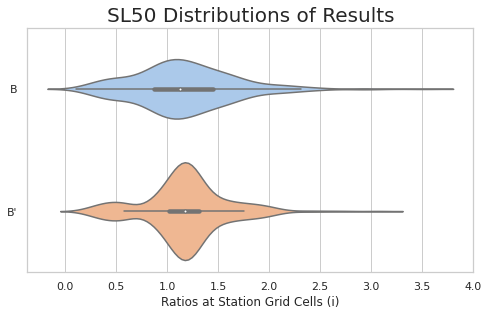

In [14]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 4.5))

violindata = np.concatenate([df.ratio, ratio_field[df.irlat, df.irlon]])

b_str = ["B" for x in df.ratio.values]
bp_str = ["B'" for x in ratio_field[df.irlat, df.irlon]]

vstrings = np.concatenate([b_str, bp_str])
vdf = pd.DataFrame({"Ratios at Station Grid Cells (i)": violindata, '': vstrings})

ax.set_title(f"{name} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x="Ratios at Station Grid Cells (i)", y='', data=vdf, palette=sns.color_palette('pastel'))

Summarize reconstruction stats

In [15]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 1.9417615457625375 
UAA_station_mean 1.5000000000000002 
Combined 1.720880772881269


Convert back to degC if K was used in previous steps. Generate dataset.

In [16]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    reconstructed_field -= K
    df[station_dv] -= K
#     ds[dv].attrs["units"] = "degC"

ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

# Load in NBCC Tables for Comparisons

In [17]:
nrc_path = resource_filename("climpyrical", nbcc_loc_path)
df_nrc = pd.read_excel(nrc_path).iloc[:-1]

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# process to get the model values
df_nrc.rename(columns={"2020 Longitude": "lon",
                      "2020 Latitude": "lat"})

df_nrc_matched = pd.DataFrame(
    {
     'Location': df_nrc.Location, 
     'Prov': df_nrc.Prov,
     "2020 Elev (m)": df_nrc["2020 Elev (m)"],
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
    
)

__This step aims to correct the final field to the NBCC 2015 results.__

This is configurable by setting `nbcc_median_correction` to True or False.

1) Find the median of these values. Compute the difference, d = median(R) - median(NRC), and ratio, f = median(R)/median(NRC) 

2) For the non-temperature DVs and HDD, apply the multiplicative correction (1/f)*R_j over the entire reconstruction grid. For the temperature DVs, apply the correction as R_j - d

In [18]:
value = medians["value"]
action = medians["action"]

if action != "add" and action != "multiply" and action != "None":
    raise ValueError("Please provide either add or multiply or None actions in config.")

    
dfp = add_model_values(ds=ds_recon, df=df_nrc_matched)
reconstructed_field_med = ds_recon[dv].values

if nbcc_median_correction:
    if value != "None" or action != "None":
#         med_pcic = np.nanmedian(dfp["model_values"])
        med_pcic = np.nanmean(dfp["model_values"])

        if action == "multiply":
            fr = med_pcic/value
            reconstructed_field_med = (1/fr)*reconstructed_field_med
            print("f:", fr)
        if action == "add":
            d = med_pcic - value
            reconstructed_field_med = reconstructed_field_med - d
            print("d:", d)

INFO:root:Detect units: kPa


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


Re-create dataset if median correction applied

In [19]:
ds_recon = gen_dataset(dv, reconstructed_field_med, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Populate with headers from the input processed model.

In [20]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [21]:
ds_recon.to_netcdf(
    resource_filename(
        "climpyrical",
        f"{output_reconstruction_path}{name}_reconstruction.nc"
    ),
    mode="w"
)